In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

# Load Fashion MNIST

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# one-hot encode labels
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

sample_size = 5000
test_size = 1000

train_idx = np.random.choice(len(x_train), sample_size, replace=False)
test_idx = np.random.choice(len(x_test), test_size, replace=False)

x_train = x_train[train_idx]
y_train_cat = y_train_cat[train_idx]
y_train_raw = y_train[train_idx]

x_test = x_test[test_idx]
y_test_cat = y_test_cat[test_idx]
y_test_raw = y_test[test_idx]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
def prepare_dataset(x, y, img_size=224):
    x = np.expand_dims(x, -1)
    x_rgb = np.concatenate([x, x, x], axis=-1)
    ds = tf.data.Dataset.from_tensor_slices((x_rgb, y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [img_size, img_size]), y))
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(x_train, y_train_cat)
test_ds = prepare_dataset(x_test, y_test_cat)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

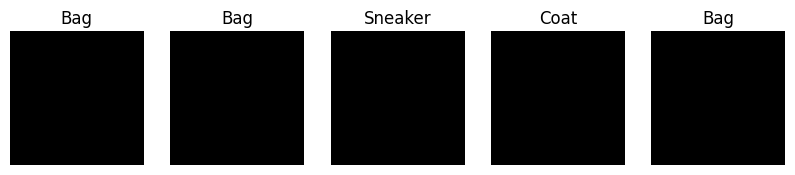

In [4]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.show()

# EfficientNetB0 Transfer Learning

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet(input_shape=(224, 224, 3), num_classes=10):
    base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    base.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

efficientnet_model = build_efficientnet()
efficientnet_model.fit(train_ds, validation_data=test_ds, epochs=3)
efficientnet_results = efficientnet_model.evaluate(test_ds)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 180ms/step - accuracy: 0.0960 - loss: 2.3461 - val_accuracy: 0.1050 - val_loss: 2.3019
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.0965 - loss: 2.3024 - val_accuracy: 0.1140 - val_loss: 2.3028
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.1020 - loss: 2.3025 - val_accuracy: 0.1140 - val_loss: 2.3028
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1114 - loss: 2.3027


# ResNet50V2 (BiT-style)

In [6]:
from tensorflow.keras.applications import ResNet50V2

def build_bit(input_shape=(224, 224, 3), num_classes=10):
    base = ResNet50V2(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    base.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

bit_model = build_bit()
bit_model.fit(train_ds, validation_data=test_ds, epochs=3)
bit_results = bit_model.evaluate(test_ds)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.7015 - loss: 0.9541 - val_accuracy: 0.8130 - val_loss: 0.4993
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.8710 - loss: 0.3615 - val_accuracy: 0.8600 - val_loss: 0.4078
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9052 - loss: 0.2760 - val_accuracy: 0.8590 - val_loss: 0.4267
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8638 - loss: 0.4222


# ConvNeXt-Like Architecture

In [7]:
def build_convnext(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    for filters in [128, 256, 512]:
        prev_x = layers.Conv2D(filters, 2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)
        x = layers.DepthwiseConv2D(7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters*4, 1, activation="gelu")(x)
        x = layers.Conv2D(filters, 1)(x)
        x = layers.add([x, prev_x])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

convnext_model = build_convnext()
convnext_model.fit(train_ds, validation_data=test_ds, epochs=2)
convnext_results = convnext_model.evaluate(test_ds)

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - accuracy: 0.2910 - loss: 3.0185 - val_accuracy: 0.6660 - val_loss: 0.9978
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6501 - loss: 0.9357 - val_accuracy: 0.6750 - val_loss: 1.0179
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6878 - loss: 0.9902


# Compare and Visualize Results

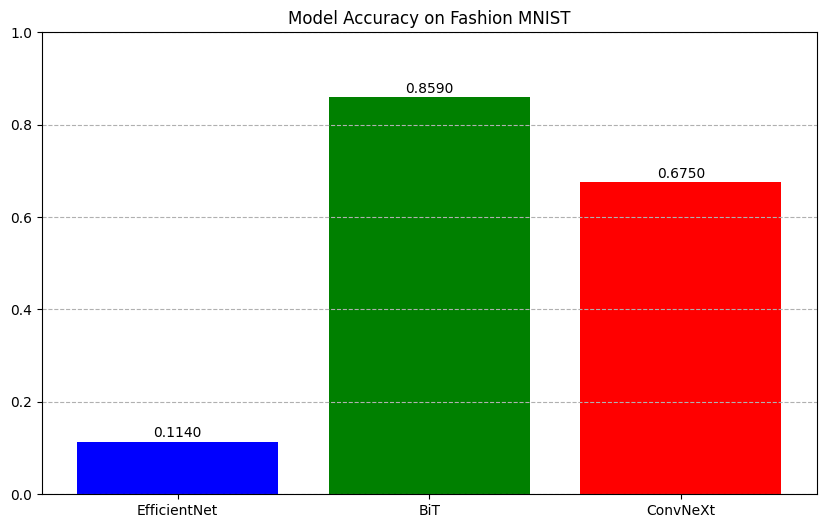

In [8]:
model_names = ["EfficientNet", "BiT", "ConvNeXt"]
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=["blue", "green", "red"])
plt.title("Model Accuracy on Fashion MNIST")
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha="center")
plt.grid(axis="y", linestyle="--")
plt.show()

# Confusion Matrix of Best Model

In [10]:
best_idx = np.argmax(accuracies)
best_name = model_names[best_idx]
print(f"Best performing model: {best_name} ({accuracies[best_idx]:.4f})")

best_model = {
    "EfficientNet": efficientnet_model,
    "BiT": bit_model,
    "ConvNeXt": convnext_model
}[best_name]

Best performing model: BiT (0.8590)


In [12]:
# predictions
y_true = []
y_pred = []
for batch_x, batch_y in test_ds:
    preds = best_model.predict(batch_x)
    y_true.extend(np.argmax(batch_y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/ste

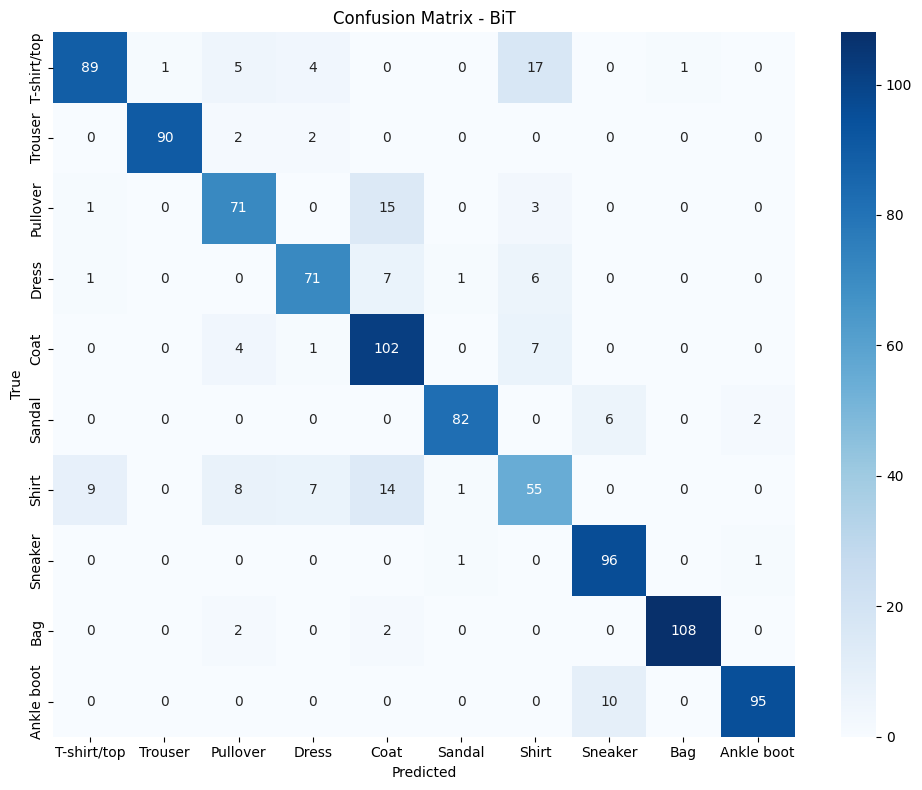

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()